RL - 10 armed - Multi Armed Bandit simulation


2000 copies of bandit each simulated for 1000 steps

Box Muller method for Simulation N(0,1) generation - generation code referred online

Action	At = { argmax Q(t) w.p (1-epsilon)
			 { any random arm w.p epsilon/k (for k arms)

Output - Plots over epsilon value ranging between [0, 0.01, 0.1, 0.2]
(for y axis over x axis)
1) Avg reward over # of steps across various epsilons
2) % of time that optimal action is picked over # of steps

** Note - For each bandit's copy - first 5 times each arm would be explored under explicit exploration steps

In [1]:
from numpy import random, sqrt, log, sin, cos, pi
from functools import wraps
from multiprocessing import Pool
import tqdm
import time
import pandas as pd

_NUMBER_OF_ARMS = 10
_SIMULATION_STEPS = 1000
_COPIES_OF_BANDITS = 2000
_INITIAL_EXPLORATION_STEPSIZE = 5 # for each arm
_EPSILON_SEQUENCE = [0, 0.01, 0.1, 0.2] # list of epsilons to try out

In [2]:
def timed(func):
    """This decorator prints the execution time for the decorated function."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("{} ran in {}s".format(func.__name__, round(end - start, 2)))
        return result
    return wrapper

In [3]:
def _box_muller(u1,u2):
    z1 = sqrt(-2*log(u1))*cos(2*pi*u2)
    z2 = sqrt(-2*log(u1))*sin(2*pi*u2)
    return z1,z2


def _get_distribution():
	random.seed() # set a random seed
	u1 = random.rand(_SIMULATION_STEPS)
	u2 = random.rand(_SIMULATION_STEPS)

	z1,z2 = _box_muller(u1, u2)
	return z2


def init_bandit_reward_distribution():
	df = pd.DataFrame()
	for i in range(0, _NUMBER_OF_ARMS):
		df[str(i)+'_arm'] = _get_distribution()
	return df

In [4]:
def _argmax_Qt_implementation(df, relevant_cols):
	"given rewards obtained for all arm, find column with max reward"
	return df[relevant_cols].mean(axis=0).idxmax()


def epsilon_greedy_strategy(df, epsilon, relevant_cols):
	if random.random() < (1 - epsilon):
		# argmax
		return _argmax_Qt_implementation(df, relevant_cols)
	else:
		# random column for arm
		return str(random.randint(0, _NUMBER_OF_ARMS)) + '_arm'


def run_simulation(kwargs):

	# get bandit rewards distribution
	bandit_reward_distribution_df = init_bandit_reward_distribution()

	# Initial few times each arm would be explored under explicit exploration (discussed in class)
	# Here I assume we have these rewards pre-present in DF
	bandit_simulation_df = bandit_reward_distribution_df[:_INITIAL_EXPLORATION_STEPSIZE-1].copy()

	# rename columns
	arms_list = [str(i)+'_arm' for i in range(0, _NUMBER_OF_ARMS)]
	bandit_simulation_df.columns = arms_list
	# capture current action, optimal action state (used in plots)
	bandit_simulation_df['action'] = 'exploration'
	bandit_simulation_df['is_optimal_action'] = 'exploration'

	# simulating from inital exploration onwards to the # of simulation steps
	for index in range(_INITIAL_EXPLORATION_STEPSIZE, _SIMULATION_STEPS):

		action_taken = epsilon_greedy_strategy(bandit_simulation_df, kwargs['epsilon'], arms_list)
		reward_received = bandit_reward_distribution_df[action_taken][index]

		# initialize empty reward state and assign reward for action
		curr_instance = {arm:0 for arm in arms_list}
		curr_instance[action_taken] = reward_received

		# map action
		curr_instance['action'] = action_taken
		# find optimal action from reward distribution of bandit at instance of current index
		optimal_action = _argmax_Qt_implementation(bandit_reward_distribution_df[:index], arms_list)
		curr_instance['is_optimal_action'] = int(action_taken == optimal_action)  # True/False as 1/0

		# append instance to simulation DF
		bandit_simulation_df = bandit_simulation_df.append([curr_instance], ignore_index=True)

	bandit_simulation_df['epsilon'] = kwargs['epsilon']
	bandit_simulation_df['index'] = kwargs['index']
	bandit_simulation_df['row_total_reward'] = bandit_simulation_df[arms_list].sum(axis=1)
	bandit_simulation_df['cumsum_total_reward'] = bandit_simulation_df['row_total_reward'].cumsum()
	return bandit_simulation_df

In [5]:
def init_simulation_space():

	simulation_df_list = []
	epsilon_mapping_list = _EPSILON_SEQUENCE
	epsilon_map_length = len(epsilon_mapping_list)
	kwargs = [{'epsilon':epsilon_mapping_list[index%epsilon_map_length], 'index':index} for index in range(0, _COPIES_OF_BANDITS)]

	for index in range(0, _COPIES_OF_BANDITS):

		simulation_df = run_simulation(kwargs[index])

		simulation_df_list.append(simulation_df)
		print('simulation iteration: ', index)

	bandit_simulation_data_df = pd.concat(simulation_df_list)
	return bandit_simulation_data_df

# using multiprocessing to speed up execution
# using tqdm to visualise a progress bar
def init_parallel_simulation_space():
	simulation_df_list = []
	epsilon_mapping_list = _EPSILON_SEQUENCE
	epsilon_map_length = len(epsilon_mapping_list)

	pool = Pool()

	kwargs = [{'epsilon':epsilon_mapping_list[index%epsilon_map_length], 'index':index} for index in range(0, _COPIES_OF_BANDITS)]
	for x in tqdm.tqdm(pool.imap_unordered(run_simulation, kwargs), total=len(kwargs)):
		simulation_df_list.append(x)

	bandit_simulation_data_df = pd.concat(simulation_df_list)
	return bandit_simulation_data_df

In [6]:
df = init_parallel_simulation_space()
# total time taken 1.14 Hrs

100%|██████████| 2000/2000 [1:14:58<00:00,  2.25s/it]


In [7]:
len(df)

1998000

In [8]:
df = df[df['action']!='exploration'] # ignore initial explicit exploration phase

In [9]:
# total reward at each step for all bandits
df.reset_index().plot(x='level_0', y='cumsum_total_reward', kind='line')

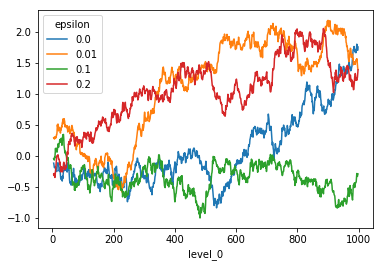

In [10]:
# Avg reward over each step across various epsilons
df.reset_index().groupby(['level_0', 'epsilon']).mean().reset_index().pivot(index='level_0', columns='epsilon', values='cumsum_total_reward').plot()

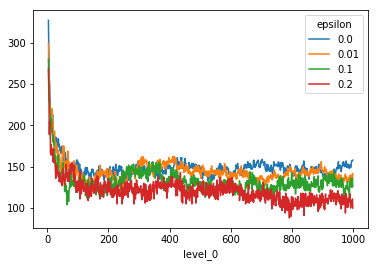

In [11]:
# number of times optimal action is chosen
df.reset_index().groupby(['level_0', 'epsilon'])[['is_optimal_action']].sum().reset_index().pivot(index='level_0', columns='epsilon', values='is_optimal_action').plot(kind='line')

In [12]:
df.head()

,0_arm,1_arm,2_arm,3_arm,4_arm,5_arm,6_arm,7_arm,8_arm,9_arm,action,is_optimal_action,epsilon,index,row_total_reward,cumsum_total_reward
4,0.0,0.0,0.000000,0.0,0.643719,0.0,0.0,0.0,0.0,0.0,4_arm,0,0.2,3,0.643719,-0.326920
5,0.0,0.0,0.000000,0.0,-0.234494,0.0,0.0,0.0,0.0,0.0,4_arm,1,0.2,3,-0.234494,-0.561414
6,0.0,0.0,-0.962375,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2_arm,0,0.2,3,-0.962375,-1.523789
7,0.0,0.0,0.000000,0.0,1.632069,0.0,0.0,0.0,0.0,0.0,4_arm,0,0.2,3,1.632069,0.108280
8,0.0,0.0,0.000000,0.0,0.858029,0.0,0.0,0.0,0.0,0.0,4_arm,0,0.2,3,0.858029,0.966310


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990000 entries, 4 to 998
Data columns (total 16 columns):
0_arm                  float64
1_arm                  float64
2_arm                  float64
3_arm                  float64
4_arm                  float64
5_arm                  float64
6_arm                  float64
7_arm                  float64
8_arm                  float64
9_arm                  float64
action                 object
is_optimal_action      object
epsilon                float64
index                  int64
row_total_reward       float64
cumsum_total_reward    float64
dtypes: float64(13), int64(1), object(2)
memory usage: 258.1+ MB
